In [1]:
from __future__ import division
import os
import itertools as it
from collections import defaultdict
from glob import glob
from math import sqrt

In [2]:
import numpy as np
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.spatial import distance, Delaunay, Voronoi
from scipy.stats import rv_continuous, vonmises

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt, cm, colorbar, rc, rcParams, gridspec

In [4]:
from PIL import Image

In [5]:
import orientation as orient
import correlation as corr
import otracks, tracks
import helpy

In [ ]:
map(reload,(orient, corr, tracks, otracks, helpy))

[<module 'orientation' from 'orientation.py'>,
 <module 'correlation' from 'correlation.pyc'>,
 <module 'tracks' from 'tracks.pyc'>,
 <module 'otracks' from 'otracks.pyc'>,
 <module 'helpy' from 'helpy.pyc'>]

In [ ]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
rc('figure', dpi=300)

In [ ]:
smallfig = (5,4)
largefig = (8,6)

In [ ]:
# Pixel-Physical Unit Conversions
mm_per_inch = 25.4
# Physical measurements
R_inch = 4.0           # as machined
R_mm   = R_inch * mm_per_inch
S_measured = .309 + 1e-4*np.array([4,3,6,7,9,1,9,0,0,4,7,5,3,6,2,6,
                                   0,8,8,4,3,4,0,-1,0,1,7,7,5,7])
S_inch = S_measured.mean()
S_mm = S_inch * mm_per_inch
R_S = R_inch / S_inch

# Digital measurements
R_pix = 2459 / 2
S_pix = np.array([3.72, 2.28, 4.34, 3.94, 2.84, 4.23, 4.87, 4.73, 3.77]) + 90

# Conversion
pix = R_pix / R_inch    # pixels per inch
inch = 1 / pix          # inches per pixel
mm = inch * mm_per_inch # mm per pixel

# What we'll use:
R = R_S     # radius in particle units
S = R_pix/R # particle in pixels
print R, S, R_pix

12.9275518449 95.1069479167 1229.5


In [ ]:
pi = np.pi
tau = 2*pi
# N = max number of particles (πR^2)/S^2 where S = 1
Nb = lambda margin: pi * (R - margin)**2
N = Nb(0)
print N, R, S

525.027980455 12.9275518449 95.1069479167


n: 272 288 304 320 336 344 352 360 368 376 384 392 400 408 416 424 432 448 464
dn: 16 16 16 16 8 8 8 8 8 8 8 8 8 8 8 8 16 16


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


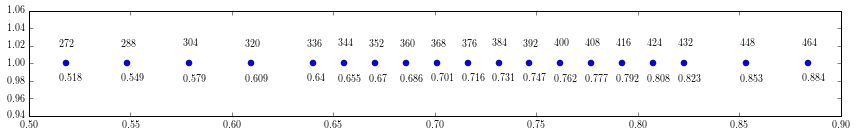

In [ ]:
datadir = "../orientation/equilibrium/"
prefix = "equilibrium"
graphicsdir = '../writing/graphics/'
save = False
savedir = graphicsdir if save else "../writing/tmp/"
ns = np.unique([int(c[1:]) for f in glob(datadir+prefix+'*')
                for c in f.split('_') if c.startswith('n')])
#ns = np.array([8,16,32,64,128,192,256,320,336,352,368,384,400,416,432,448])
#ns = np.array([272, 288, 304, 320, 336, 344, 352, 360, 368, 376,
#               384, 392, 400, 408, 416, 424, 432, 448, 464])
plt.figure(figsize=(12, 2))
plt.plot(ns/N, np.ones_like(ns), 'o')
[plt.text(n/N - 0.003, 1.02, str(n)) for n in ns]
[plt.text(n/N - 0.003, 0.98, "{:.3}".format(n/N)) for n in ns]
print 'n:', ' '.join(map(str, ns))
print 'dn:', ' '.join(map(str, np.diff(ns)))

In [ ]:
def load_from_npz(prefix, locdir=None):
    """ given a prefix, returns:
        data, cdata, odata, omask
        """
    if locdir is None:
        from os import getcwd
        locdir = getcwd() +'/'
    path = locdir+prefix
    datanpz = np.load(path+'_POSITIONS.npz')
    cdatanpz = np.load(path+'_CORNER_POSITIONS.npz')
    odatanpz = np.load(path+'_ORIENTATION.npz')
    return {'data': datanpz['data'], 'cdata': cdatanpz['data'],
            'odata': odatanpz['odata'], 'omask': odatanpz['omask']}

In [12]:
alldata = {n: load_from_npz(prefix+'_n'+str(n), locdir=datadir) for n in ns}

In [ ]:
# Load the testing data from frame zero of each density:
datadir = "../orientation/equilibrium_detection_testing/"
path = (datadir+'{}_POSITIONS.npz').format
paramsets = {pset: np.load(path(pset))['data']
             for pset in ['f0', 'f0_min600', 'f0_ecc6']}
# 'f0':        k: 22, size: 800-1600, ecc: 0.7
# 'f0_min600': k: 22, size: 600-1600, ecc: 0.7
# 'f0_ecc6':   k: 22, size: 600-1600, ecc: 0.6
# 'f0_ecc5':   k: 22, size: 600-1800, ecc: 0.5

In [ ]:
# Load the testing corner data from frame zero of each density:
path = (datadir+'{}_CORNER_POSITIONS.npz').format
cparamsets = {pset: np.load(path(pset))['data']
              for pset in ['f0_c65-250', 'f0_c65-250_e7',
                           'f0_c75-225', 'f0_c75-225_e7', 'f0_c80-200']}
# above datasets have the parameters
# ck: 5, csize: [65-250, 75-225, 80-200], cecc: [0.7, 0.8]

In [ ]:
# Count false positives and false negatives ('extras' and 'missed')

fpids = {
    'f0': defaultdict(list,
                {256: [122], 272: [266], 288: [35,112,150,271], 304: [107,145,161],
                 320: [88,121,164,184,207,227], 328: [159], 336: [123],}),
    'f0_ecc6': defaultdict(list,
                {256: [72,123,249], 272: [254,268], 288: [35,111,244,246,282],
                 304: [7,108,146,162,187], 320: [55,89,147,165,185,193,228,300,331],
                 328: [63,165,270], 384: [240], 392: [271], 408: [286], 448: [325],}),
    'f0_min600': defaultdict(list,
                {256: [35,73,124,250], 272: [209,255,265,270],
                 288: [35,112,150,246,248,274,285],
                 304: [7,108,117,147,152,164,189,245,251],
                 320: [55,89,122,148,166,186,194,210,230,302,333],
                 328: [63,160,167,273,293], 336: [124], 344: [219,242,265],
                 352: [266,284], 384: [240], 392: [271], 408: [287], 448: [325],}) }

In [ ]:
pset = 'f0'#'f0_c80-200'
for n, d in it.izip(ns, helpy.splitter(paramsets[pset])):
    #if n != 408: continue
    pts = np.column_stack([d['x'], d['y']])
    plt.figure(figsize=(20,16))
    bgimage = np.asarray(Image.open(datadir+'n{}_0.JPG'.format(n)))
    plt.imshow(bgimage, origin='lower')
    plt.scatter(pts[:,1], pts[:,0], marker='o', c='k')#np.repeat(['r','g','b'], 20))
    # cover the false positives:
    plt.scatter(pts[fpids[pset][n],1], pts[fpids[pset][n],0], c='w', marker='o')
    for i, pt in enumerate(pts):
        # print point index next to each point
        x, y = pt
        plt.text(y, x, i, size=9, color='k')
    plt.title("found {} of {} particles\n n{:03d}_0.JPG".format(len(pts), (n+16), n))
    #plt.title("found {} of {} corners\n n{:03d}_0.JPG".format(len(pts), (n+16)*3, n))
    #plt.savefig(datadir+pset+"_CENTERS.png")

In [ ]:
# Histograms of size and eccentricity of the false positives
extras = {pname: np.array([fpi for fpv in fpids[pname].values() for fpi in paramset[fpv]])
                  for pname in paramsets}
for pname, pset in paramsets.iteritems():
    plt.figure()
    plt.hist(pset['area'], label='All', normed=True)
    plt.hist(extras[pname]['area'], label='Extras', normed=True, alpha=.75)
    plt.title(pname + ': Area')

    plt.figure()
    bins = np.linspace(0,1,21)
    plt.hist(pset['ecc'], bins, label='All', normed=True)
    plt.hist(extras[pname]['ecc'], bins, label='Extras', normed=True, alpha=.75)
    plt.title(pname + ': Ecc')
    plt.xticks(np.arange(0,1,.1))

In [ ]:
cropped = np.asarray(Image.open(savedir+'n400.jpg'))
full = np.asarray(Image.open(savedir+'n400_2013_11_20_162422.JPG'))
im_names = np.array([
        162119, 162128, 162136, 162145, 162151, 162159, 162207, 162214, 162222,
        162230, 162237, 162244, 162253, 162301, 162309, 162318, 162325, 162335,
        162343, 162351, 162359, 162407, 162415, 162422, 162429, 162436, 162444,
        162452, 162500, 162507, 162515, 162522, 162530, 162538, 162547, 162555,
        162603, 162610, 162618, 162627, 162636, 162644, 162652, 162701, 162709,
        162716, 162724, 162732, 162740, 162747, 162755, 162803, 162813, 162822,
        162831, 162839, 162848, 162856, 162904, 162912, 162921, 162928, 162936,
        162944, 162952, 162959, 163007, 163015, 163024, 163031, 163038, 163046,
        163054, 163101, 163109, 163116, 163124, 163134, 163146, 163155, 163203,
        163211, 163218, 163227, 163235, 163243, 163250, 163259, 163306, 163314,
        163321, 163329, 163337, 163346, 163353, 163400, 163407, 163416, 163423,
        163431, 163438, 163446, 163453, 163502, 163510, 163518, 163525, 163533,
        163542, 163550, 163559, 163607, 163615, 163623, 163631, 163639, 163647,
        163655, 163703, 163712, 163719, 163728, 163737, 163746, 163755, 163804,
        163812, 163819, 163827, 163834, 163842, 163850, 163858, 163906, 163914,
        163921, 163929, 163938, 163945, 163953, 164001, 164009, 164017, 164026,
        164034, 164043, 164051, 164059, 164107, 164116, 164125, 164135, 164142,
        164150, 164159, 164207, 164214, 164222, 164230, 164238, 164247, 164255,
        164304, 164312, 164321, 164329, 164337, 164345, 164354, 164402, 164409,
        164417, 164424, 164431, 164440, 164449, 164458, 164507, 164515
    ])
im_i = np.searchsorted(im_names, 162422)
h, w, _ = cropped.shape
x0, y0 = 1486, 822

data = alldata[416]
om = data['omask']
d = data['data'][om]
dfm = d['f']==im_i
d = d[dfm]

c = data['cdata']
cfm = c['f']==im_i
c = c[cfm]

o = data['odata'][om][dfm]['cdisp']

In [ ]:
data.keys(), d.shape, c.shape, o.shape

(['odata', 'data', 'omask', 'cdata'], (413,), (1250,), (413, 2))

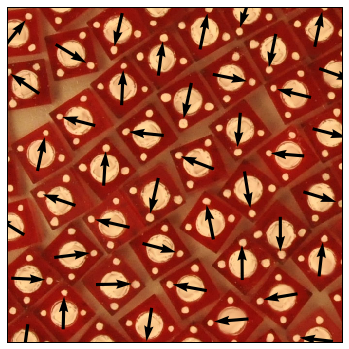

In [ ]:
save = True
scale = .75
mark = 'quiver'# 'marked'
plt.figure(figsize=(6,6))
plt.imshow(cropped, origin='lower', extent=(x0, x0 + w, y0, y0+h))
if mark=='marked':
    plt.scatter(d['y'], d['x'], marker='.', c='k')
    plt.scatter(c['y'], c['x'], marker='+', c='k')
if mark=='quiver':
    plt.quiver(d['y'], d['x'],   # vector base location
               o[:, 1], o[:, 0], # vector components
               scale = 6*S*scale, width=7e-3/scale, pivot='mid')
plt.xlim(x0, x0+w*scale)
plt.ylim(y0, y0+h*scale)
plt.xticks([])
plt.yticks([])
if save: plt.savefig(savedir + 'n400_{}_s{:0.2f}.png'.format(mark, scale),
                     dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
# Exclude and plot Marginal Particles to find Bulk Density
margin = 2
Nb_margin = Nb(margin)
fmt = "{:9} actual = {}, total = {}, bulk = {}, bulk (corrected) = {}".format
impath = (datadir+'../equilibrium_detection_testing/n{}_0.JPG').format
stripe_colors = np.repeat(list('rgb'), 20)
for n, data in sorted(alldata.items())[-1:]:
    for d in helpy.splitter(data['data'], data['data']['f'])[:1]:
        pts = helpy.consecutive_fields_view(d, 'xy')
        plt.figure(figsize=(20,16))
        bgimage = np.asarray(Image.open(impath(n-16)))
        plt.imshow(bgimage, origin='lower')
        plt.scatter(pts[:,1], pts[:,0], marker='o', c='k')#c=stripe_colors)
        bn, bmask = corr.bulk(pts, margin=margin, radius=R)
        bn_corr, bmask = corr.bulk(pts, margin=margin, full_N=n, radius=R)
        print fmt("Counts:",  n,   len(pts),   bn,           bn_corr)
        print fmt("Density:", n/N, len(pts)/N, bn/Nb_margin, bn_corr/Nb_margin)
        plt.scatter(pts[bmask,1], pts[bmask,0], marker='o', c='w')#c=stripe_colors)

Counts: N_actual = 464, N_found = 465, N_bulk = 325, N_bulk (corrected) = 324.301075269
Density: actual = 0.883762422716, average = 0.885667083109, bulk = 0.866338743706, corrected = 0.864475649634


In [ ]:
# Find Average Bulk Density for each N (average over all frames)
density = defaultdict(dict)
densities = defaultdict(lambda: np.zeros_like(ns, float))
bulkmask = defaultdict(dict)

fmt = "{:9} actual = {}, total = {}, bulk = {}, bulk (corrected) = {}".format
for margin in xrange(5):
    Nb_margin = Nb(margin)
    for n in sorted(alldata):
        #if n != 272: continue
        d = alldata[n]['data']
        pts = helpy.consecutive_fields_view(d, 'xy')
        nf = np.count_nonzero(np.bincount(d['f']))
        bn, bmask = corr.bulk(pts, margin=margin, full_N=n*nf, radius=R, ss=S)
        #print fmt("Counts:",  n,   len(pts)/nf,   bn/nf,           bn_corr/nf)
        #print fmt("Density:", n/N, len(pts)/N/nf, bn/Nb_margin/nf, bn_corr/Nb_margin/nf)
        density[margin][n] = bn/Nb_margin/nf
        #density_std[margin][n] = (bn/Nb_margin).std()
        densities[margin][np.searchsorted(ns, n)] = bn/Nb_margin/nf
        bulkmask[margin][n] = bmask
        #plt.figure()
        #plt.scatter(pts[1], pts[0])
density = dict(density)
densities = dict(densities)
bulkmask = dict(bulkmask)

272: 0.517=0.517 ± 0.00916=0.00072
288: 0.537=0.535 ± 0.00947=0.00192
304: 0.565=0.564 ± 0.00971=0.00059
320: 0.586=0.586 ± 0.00843=0.00001
336: 0.623=0.622 ± 0.01283=0.00067
344: 0.614=0.614 ± 0.00842=0.00016
352: 0.632=0.632 ± 0.00732=0.00010
360: 0.638=0.638 ± 0.00674=0.00008
368: 0.652=0.652 ± 0.00612=0.00012
376: 0.670=0.671 ± 0.00673=0.00043
384: 0.686=0.686 ± 0.00558=0.00017
392: 0.702=0.702 ± 0.00546=0.00019
400: 0.727=0.727 ± 0.00469=0.00055
408: 0.744=0.745 ± 0.00396=0.00037
416: 0.759=0.760 ± 0.00250=0.00003
424: 0.766=0.766 ± 0.00100=0.00000
432: 0.787=0.787 ± 0.00155=0.00000
448: 0.822=0.822 ± 0.00108=0.00003
464: 0.865=0.865 ± 0.00134=0.00000


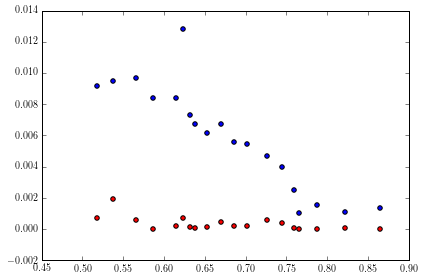

In [ ]:
# Find Variance in Bulk Density for each N (Must loop through individual frames)
#density    = defaultdict(dict)
#densities  = defaultdict(lambda: np.zeros_like(ns, float))
density_std = defaultdict(dict)
#bulkmask   = defaultdict(dict)
for margin in [2]:
    Nb_margin = Nb(margin)
    for n, nd in sorted(alldata.items()):
        #print '---- N', n, '----'
        ndens = []
        for df in helpy.splitter(nd['data']):
            pts = np.column_stack([df['x'], df['y']])
            bn, bmask = corr.bulk(pts, margin=margin, full_N=n, radius=R, ss=S)
            #print len(pts),bn
            ndens.append(bn/Nb_margin)
        #print density[margin][n], np.mean(ndens)
        density_std[margin][n] = np.std(ndens)#/sqrt(len(ndens))
        print "{:d}: {:5.3f}={:5.3f} ± {:.5f}={:.5f}".format(
            n, np.mean(ndens), density[margin][n], density_std[margin][n],
            np.abs(np.mean(ndens) - density[margin][n]))
        plt.scatter(np.mean(ndens), density_std[margin][n])
        plt.scatter(np.mean(ndens), np.abs(np.mean(ndens) - density[margin][n]), c='r')

In [ ]:
density_std[2]

{272: 0.007601383635803885,
 288: 0.0080485238496747873,
 304: 0.0084956640635454363,
 320: 0.0089428042774163975,
 336: 0.0093899444912867169,
 344: 0.0096135145982221733,
 352: 0.0098370847051578759,
 360: 0.010060654812093221,
 368: 0.010284224919028671,
 376: 0.010507795025963905,
 384: 0.010731365132899552,
 392: 0.010954935239834896,
 400: 0.011178505346770824,
 408: 0.011402075453705741,
 416: 0.011625645560641358,
 424: 0.011849215667576418,
 432: 0.012072785774512273,
 448: 0.012519925988382636,
 464: 0.012967066202253677}

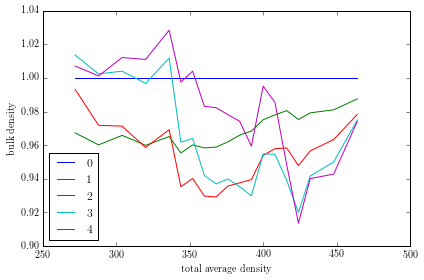

In [ ]:
plt.plot(ns, np.column_stack(densities.values())*N/ns[:, None])
#plt.plot(ns/N, densities[0])
#plt.plot(ns/N, densities[1])
#plt.plot(ns/N, densities[2])
plt.legend(np.arange(5), loc='best')
plt.xlabel('total average density')
plt.ylabel('bulk density')

0.0276404325066 0.877378022654


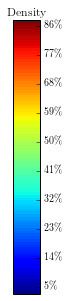

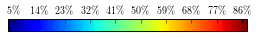

In [15]:
"I hate you, matplotlib:"
"http://matplotlib.org/examples/pylab_examples/histogram_percent_demo.html"
save = False
full = True
if save:
    rc('text', usetex=save)

from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize

alldensities = np.concatenate(densities.values())
if full:
    # use the densities from diffusion.ipynb
    dmin, dmax = 0.0276404325066, 0.877378022654
else:
    dmin, dmax = alldensities.min(), alldensities.max()
print dmin, dmax
#dmin, dmax = 8/N, 448/N # for "spatial_density" data
col = lambda dens: cm.jet((dens - dmin)/(dmax - dmin))

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = "{:.0%}".format(y)

    # The percent symbol needs escaping in latex
    if rcParams['text.usetex'] is True:
        return s[:-1] + r'$\%$'
    else:
        return s

formatter = FuncFormatter(to_percent)
normz = Normalize(vmin=dmin, vmax=dmax)
#normz.autoscale(ns/N)
vvv = np.linspace(dmin, dmax, 100, endpoint=True)
#cbax, options = colorbar.make_axes(plt.axes([0,0,.1,1]))
for baro in ['v', 'h']:
    fig = plt.figure(figsize=((3.5,.4) if baro is 'h' else (.75,4)))
    colorbar.ColorbarBase(fig.add_axes([.025, # left
                                        .025, # bottom
                                        .95 if baro is 'h' else .50,   # width
                                        .40 if baro is 'h' else .95]), # height
                norm=normz, boundaries=vvv, values=(vvv[1:]+vvv[:-1])*.5, cmap=cm.jet,
                format=formatter, orientation='horizontal' if baro is 'h' else 'vertical',
                ticks=np.around(np.arange(dmin + .025, dmax, round((dmax-dmin)/9, 2)), 2),
                ticklocation='top' if baro is 'h' else 'right')
    if baro is 'v': plt.title('      Density')
    if save: fig.savefig(savedir+'colorbar_{}{}.pdf'.format(baro[0], '_full'*full))

if full:# redefine col and dmin dmax accurately
    dmin, dmax = alldensities.min(), alldensities.max()
    col = lambda dens: cm.jet((dens - dmin)/(dmax - dmin))

In [ ]:
decays = {'exp': corr.exp_decay,
          'pow': corr.powerlaw}

## Particle Orientation Order parameters

Histogram of all orientations modulo 90°, where the angle is measured perpendicular to the most common orientation

For a global measure of orientational order across the entire disk, we can measure the order parameter for particle orientation, given by $\Phi_m = \langle e^{im\theta}\rangle$, average is over all particles in a given frame.  This leaves us with a complex value with an arbitrary phase.  To obtain the full average, we take the magnitude of $\Phi_m$ and average that over all frames for a given density.

In [ ]:
# Uncomment to clear variables
#locphi, locphi_err, globphi, globphi_err = {}, {}, {}, {}

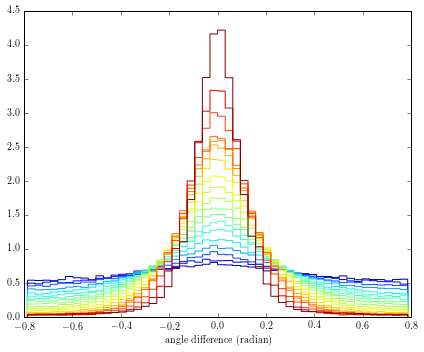

In [ ]:
do_odiff = True
do_local = False
do_global = True
save = False
bins = 50
m = 4
margin = 2
if do_global:
    globphi[m] = []
    globphi_err[m] = []
if do_local:
    locphi[m] = []
    locphi_err[m] = []
if do_odiff:
    diff_hists = {}
    diff_std = []
    plt.figure(1, figsize=(6,5))
    #plt.title('orientation differences between delaunay neighbors')
    plt.xlabel('angle difference (radian)')
for n, d in sorted(alldata.iteritems()):
    if do_odiff: dorient = []
    if do_local: locphi_n = []
    if do_global: globphi_n = []
    for f in np.unique(d['data']['f']):
        # masking/filtering:
        masks = (d['data']['f']==f) & d['omask']
        maskn = np.count_nonzero(masks)
        pts = d['data'][masks][['x','y']].view((float,2)).copy()
        orients = d['odata']['orient'][masks]
        assert pts.shape == (maskn, 2), \
            "Unexpected number of points for frame {} at number {}".format(f, n)
        if do_odiff or do_local:
            _, bulk_mask = corr.bulk(pts, margin=margin)
            vor = Voronoi(pts)
            pairs = vor.ridge_points
        if do_odiff:
            dorient.extend(corr.dtheta(*orients[pairs].T, sign=True))
        if do_local:
            phi_neigh = np.abs([np.mean(np.exp(m*orients[corr.get_neighbors(vor, i)]*1j))
                                for i in xrange(maskn)])
            locphi_n.append(np.abs(np.mean(phi_neigh)))
        if do_global:
            globphi_nf = corr.orient_op(orients, pts, m=m, margin=margin)
            globphi_n.append(globphi_nf)
    if do_odiff:
        dorient = np.asarray(dorient)
        diff_std.append(dorient.std())
        diff_hists[n] = plt.hist(dorient, bins, (-tau/8, tau/8), True,
                                 histtype='step', label=format(density[0][n], '.2%'),
                                 color=col(density[0][n]), lw=1)[:-1]
    if do_local:
        locphi_n = np.asarray(locphi_n)
        locphi[m].append(locphi_n.mean())
        locphi_err[m].append(locphi_n.std())#/np.sqrt(locphi_n.size/20.))
    if do_global:
        globphi_n = np.abs(globphi_n)
        globphi[m].append(globphi_n.mean())
        globphi_err[m].append(globphi_n.std())#/np.sqrt(globphi_n.size/10.))
if do_odiff and save:
    #plt.legend(loc='best', ncol=2, fontsize='x-small')
    plt.savefig(savedir+"odiff_delaunay.pdf")

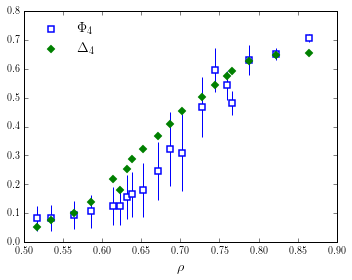

In [ ]:
# Plot the Particle Orientaion Order Parameters
# Phi_m and Delta_m
save = True
plt.figure(figsize=smallfig)
fmt = {4: 'sb', 6: 'hr'}
margin = 2
for m in [4]:
    #plt.plot(densities[0], locphi[m], shape[m],
    #         label='local '+r'$\Phi_{:d}$'.format(m), color='g')
    #plt.errorbar(densities[0], locphi[m], locphi_err[m], ls='', color='g')
    plt.plot(densities[margin], globphi[m], fmt[m],
             label=r'$\Phi_{:d}$'.format(m),
             #label=r'$\Phi_{:d}$ ({}atic)'.format(m, 'Tetr' if m==4 else 'Hex'),
             markeredgecolor=fmt[m][-1],
             markerfacecolor='w',
             markeredgewidth=1.5)
    plt.errorbar(densities[margin], globphi[m], globphi_err[m],
                 ls='', color=fmt[m][-1], capsize=0)
plt.plot(densities[margin], 1 - np.asarray(diff_std)*sqrt(12)*4/tau,
         ls='', marker=(4, 0, 1), ms=8, color='g', markeredgecolor='g',
         label=r'$\Delta_4$',) #margin=0 here
#plt.title('Particle orientational order parameter')
plt.xlabel(r'$\rho$', size='x-large')
plt.ylim(0, 0.8)
plt.legend(loc='upper left', numpoints=1, fontsize='x-large', frameon=False)
if save: plt.savefig(savedir+"orient_order_params.pdf")

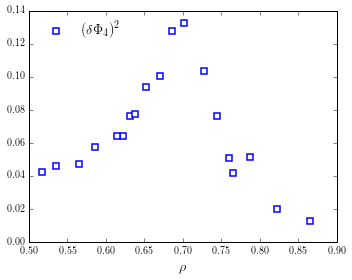

In [ ]:
# Plot Variance of Particle Orientaion Order Parameters
# Phi_m and Delta_m
save = True
rc('text', usetex=save)
plt.figure(figsize=smallfig)
fmt = {4: 'sb', 6: 'hr'}
margin = 2
for m in [4,]:
    plt.plot(densities[margin], globphi_err[m], fmt[m],
             label=r'$(\delta\Phi_{:d})^2$'.format(m),
             markeredgecolor=fmt[m][-1],
             markerfacecolor='w',
             markeredgewidth=1.5)
plt.xlabel(r'$\rho$', size='x-large')
plt.legend(loc='upper left', numpoints=1, fontsize='x-large', frameon=False)
if save: plt.savefig(savedir+"orient_order_variance.pdf")

## Particle Orientation Correlation Function $g_m(r)$

To determine the extent of particle orientational order, we use the $m$-fold particle orientational correlation function, which is given by $g_m(r) = \langle \cos[m (\theta_r - \theta_0 )] \rangle$, where the average is over all pairs of particles separated by distance between $r$ and $r + dr$, where $dr$ is implemented as ``binsize`` below.

In [ ]:
# Uncomment to clear variables
#gms = {}
#gm_fits = {'exp': {}, 'pow': {}}; gm_fiterr = {'exp': {}, 'pow': {}}

In [ ]:
rmax = 10*S # R of dish is ~12.9 S
dr = .1*S
rbins = np.arange(S - dr/2, rmax + 1.5*dr, dr)
rs = np.arange(S, rmax+dr, dr)

In [ ]:
## Calculate the particle correlation function g^\phi_m(r) and save it to `gms`
m = 4
gms[m] = {}
margin = 2
for n, d in sorted(alldata.iteritems()):
    fs = np.unique(d['data']['f'])
    gmr = np.empty(fs.shape+rs.shape, float)
    for f in fs:
        mask = (d['data']['f']==f) & d['omask']
        positions = np.column_stack([d['data'][mask]['x'], d['data'][mask]['y']])
        gmr[f], _ = corr.orient_corr(positions, d['odata']['orient'][mask],
                                     m=m, margin=margin, bins=rbins)
    gms[m][n] = (np.nanmean(gmr, 0), np.nanstd(gmr, 0), rs)

In [ ]:
## Generate fits for g^\phi_m(r)
m = 4
As = ['f', '1', 'g1'] # 'f' for free/fitted A, '1' for A=1, 'g1' for A=g(1)
for decay in ['exp', 'pow']:
    r0 = decay=='exp'
    gm_fits[decay][m] = {}
    gm_fiterr[decay][m] = {}
    for A in As:
        gm_fits[decay][m][A] = {}
        gm_fiterr[decay][m][A] = {}
        for n, (gmr, dgmr, rs) in gms[m].iteritems():
            if A == 'f':
                guess = [1,1]
                fit_func = decays[decay]
                pappendix = []
            elif A == '1':
                guess = [1]
                fit_func = decays[decay]
                pappendix = [1]
            elif A == 'g1':
                guess = [1]
                g1 = gmr[0]
                fit_func = lambda x, a: decays[decay](x, a, g1)
                pappendix = [g1]
            p, cov = curve_fit(fit_func, rs/S - r0, gmr, guess,
                               sigma=dgmr, absolute_sigma=True)
            #print "N = {}, cov = {:.4f}, fit = {}".format(n, np.linalg.norm(cov), p)
            if np.isfinite(np.linalg.norm(cov)):
                gm_fits[decay][m][A][n] = p.tolist() + pappendix
                gm_fiterr[decay][m][A][n] = np.sqrt(np.diag(cov))
            else:
                print "failed to fit {} for n = {} with A = {}".format(decay, n, A) 

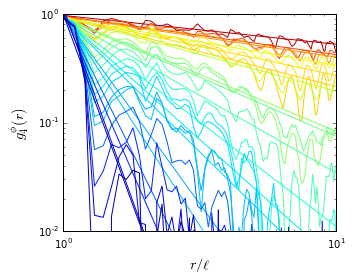

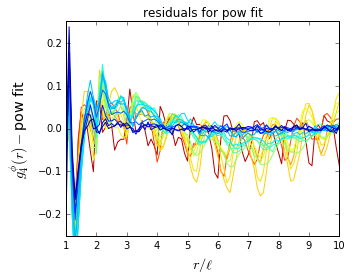

In [ ]:
## Plot g_m(r), particle orientation correlation function
 # optionally with fits and residuals
save = False
m = 4
decay = 'pow' # empty string for none, else 'exp' or 'pow'
r0 = decay=='exp'
A = 'f' #only use A = 'f' for paper.
#margin = 2
for n, (gmr, dgmr, rs) in sorted(gms[m].items(), reverse=True):
    if decay and n not in gm_fits[decay][m][A]: continue
    #if n < ns[-8]: continue
    c = col(density[margin][n])
    plt.figure(1, figsize=smallfig)
    plt.plot(rs/S, gmr, color=c)
    if decay:
        # Plot the fits
        f = decays[decay](rs/S - r0, *gm_fits[decay][m][A][n])
        plt.plot(rs/S, f, color=c)

        # and residuals
        plt.figure(2, figsize=smallfig)
        resid = gmr - f
        plt.plot(rs/S, resid,
                 label=format(density[margin][n], '.2%'), color=c)

if False:
    plt.figure(4, figsize=smallfig)
    plt.plot(rs/S, dgmr, color=c)
    plt.xscale('log')

plt.figure(1)
#plt.title('Particle orientation correlation')
plt.xlabel('$r/\ell$', size='x-large')
plt.ylabel('$g^\phi_{}(r)$'.format(m), size='x-large')
plt.ylim(1e-2, 1)
plt.xlim(1,10)
plt.yscale('log')
if not r0:
    plt.xscale('log')
if save:
    plt.savefig(savedir+"g{}_{}.pdf".format(m, decay or ('semilog' if r0 else 'loglog')))

if decay:
    # Fit Residuals
    plt.figure(2)
    plt.title('residuals for {} fit'.format(decay))
    plt.ylabel("$g^\phi_{}(r) - ${} fit".format(m, decay), fontsize='x-large')
    plt.xlabel('$r/\ell$', fontsize='x-large')
    plt.ylim(-.25,.25)
    plt.xlim(1,10)
    if save: plt.savefig(savedir+"g{}_{}_resid.pdf".format(m, decay))


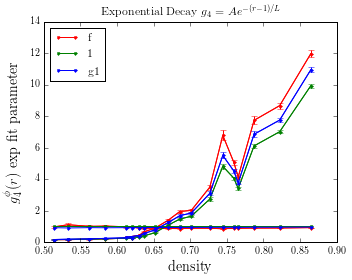

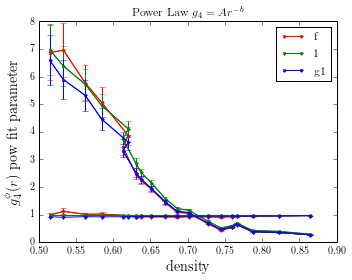

In [ ]:
## Plot best-fit parameters for decay of g_m(r)
save = True
As = ['f', '1', 'g1']
m = 4
Acol = dict(zip(As, 'rgb'))
titles = {'exp': r'Exponential Decay $g_4 = Ae^{-(r-1)/L}$',
          'pow': r'Power Law $g_4 = Ar^{-b}$'}
for decay in ['exp', 'pow']:
    plt.figure(figsize=smallfig)
    handles = []
    for A in As:
        fitns, fitps = map(np.asarray, zip(*sorted(gm_fits[decay][m][A].items())))
        #? fitns, fitps = np.asarray(sorted(gm_fits[decay][m][A].items())).T
        fitdens = [density[margin][fitn] for fitn in fitns]
        _, fitperrs = map(np.asarray, zip(*sorted(gm_fiterr[decay][m][A].items())))
        #? fitperrs = np.asarray(sorted(gm_fiterr[decay][m][A].items()))[:,1]
        for pN in xrange(fitps.shape[1]):
            try:
                plt.errorbar(fitdens, fitps[:,pN], fitperrs[:,pN], color=Acol[A])
            except IndexError:
                pass
            [handle] = plt.plot(fitdens, fitps[:,pN],
                                lw=1, marker='.', label=A, color=Acol[A])
        plt.xlabel('density', size='x-large')
        plt.ylabel(r"$g^\phi_{}(r)$ {} fit param".format(m, decay), size='x-large')
        #plt.title(r"{} fits for $g^\phi_{}(r)$".format(decay, m), size='x-large')
        handles.append(handle)
    plt.legend(handles, As, loc='best')
    plt.title(titles[decay])
    #plt.legend('$L$ ($A={0}$),$A ={0}$'.format(A).split(','), loc='best')
    #plt.legend('$b$ ($A={0}$,$A={0}$'.format(A).split(','), loc='best')
    if save: plt.savefig(savedir + "g{}_fitp_{}.pdf".format(m, decay))

## Binder Cumulant $U_L$

In [ ]:
# Calculate the Binder Cumulant
bls = np.arange(3,26,2)*S
margin=2
u = {}
for n, d in sorted(alldata.iteritems()):
    frames = np.unique(d['data']['f'])
    us = np.empty((len(frames), len(bls)))
    for fi, f in enumerate(frames):
        masks = (d['data']['f']==f) & d['omask']
        maskn = np.count_nonzero(masks)
        pts = np.column_stack([d['data'][masks]['x'], d['data'][masks]['y']])
        orients = d['odata']['orient'][masks]
        assert pts.shape == (maskn, 2), "wrong shape for 'pts'"
        assert len(pts) == len(orients), "mismatch in number particles"
        us[fi] = [corr.binder(pts, orients, bl, m=4, method='ball', margin=margin)
                  for bl in bls]
    u[str(n)] = us.mean(0)

-c:15: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
#Save Binder Cumulant
#np.savez(datadir+'equilibrium_binder_margin2_l=3,26,2', **u)

In [ ]:
#Load saved Binder Cumulant
#u = np.load(datadir+'equilibrium_binder_margin2_l=3,26,2.npz')
#bls = np.arange(3,26,2)*S

[  3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.]


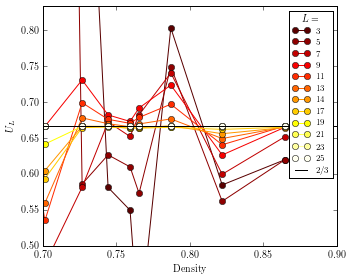

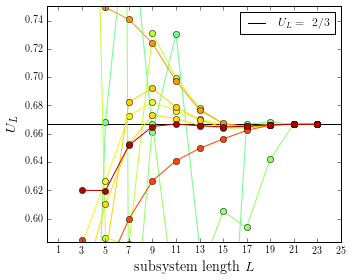

In [ ]:
print bls/S
uarr = np.row_stack(u[str(n)] for n in ns)
plt.figure(figsize=smallfig)
for ui,li in zip(uarr.T,bls/S):
    plt.plot(densities[margin], ui, 'o-', color=cm.hot(li/25.4))
plt.axhline(2/3, color='k')
uspan = 1/6
plt.ylim(2/3-uspan, 2/3+uspan)
plt.xlim(.7, .9)
plt.ylabel("$U_L$")
plt.xlabel("Density")
plt.legend(map(str, (bls/S).astype(int))+["$2/3$"],
           title="$L=$", loc='best', fontsize='small')
#plt.title("Binder cumulant")
plt.savefig(savedir+"binderT.pdf")

plt.figure(figsize=smallfig)
plt.axhline(2/3, color='k')
for ui, dens in zip(uarr, densities[margin]):
    if dens < .68: continue
    plt.plot(bls[:-1]/S, ui[:-1], 'o-', color=col(dens))
uspan = 1/12
plt.ylim(2/3-uspan, 2/3+uspan)
plt.xticks(np.r_[1,bls/S])
plt.ylabel("$U_L$", fontsize='x-large')
plt.xlabel("subsystem length $L$", fontsize='x-large')
plt.legend(["$U_L =\ 2/3$"],loc=0)#+[format(n/N,".1%") for n in ns[-11:]],
           #title="Density", loc='best', fontsize='small')
#plt.title("Binder cumulant")
plt.savefig(savedir+"binder.pdf")

## Radial Density / Pair Correlation Function $g(r)$

To determine the extent of translational order, we measure the pair correlation function $g(r)$.  This is implemented as a weighted histogram of the distances between all pairs of particles.  The amplitude envelope of $g(r)$ gives a decay shape and length scale, which we can use to quantify the range of the ordering.  To obtain the envelope, we apply a Hilbert transform to the curve after removing 

In [ ]:
if raw_input('rebuild the g(r)s? ') == 'yes':
    dr = .05 #in particle units
    gs = {}
    nin = {}
    for n, d in sorted(alldata.items()):
        ggg, eee, nin[n] = corr.build_gs(d['data'], dr=dr, rmax=15*S, margin=2*S)
        g, dg, rg = corr.avg_hists(ggg, eee)
        rdomain = rg >= S
        g = g[rdomain]
        rg = rg[rdomain]
        dg = dg[rdomain]
        gs[n] = (g, rg, dg)
elif raw_input("load g(r) and peaks from file? ") == 'yes':
    gnpz = np.load(datadir + 'equilibrium_gr_20150121.npz')
    gs = { int(n): g for n, g in gnpz.iteritems() }
    pknpz = np.load(datadir + 'equilibrium_gr_peaks.npz')
    pks = { int(n): a for n, a in pknpz.iteritems() }
    margin = 2

rebuild the g(r)s? no
load g(r) and peaks from file? yes


In [ ]:
if raw_input('save the g(r)s? ') == 'yes':
    garr = { str(n): np.vstack(gt) for n, gt in gs.iteritems() }
    np.savez(datadir + 'equilibrium_gr', **garr)
if raw_input('save the g(r) peaks? ') == 'yes':
    pks_str = { str(k): v for k, v in pks.iteritems() }
    np.savez(datadir + 'equilibrium_gr_peaks', **pks_str)

save the g(r)s? no
save the g(r) peaks? no


In [ ]:
nvn = np.array([nin[k] for k in ns])
plt.plot(ns, nvn, 'o')

NameError: name 'nin' is not defined

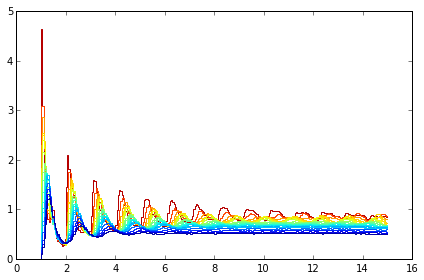

In [ ]:
margin = 2
for n in reversed(ns):
    g, rg, dg = gs[n]
    dens = density[margin][n]
    c = col(dens)
    plt.step(rg/S, g*S*S, ls='-', where='pre',
             label="{:.1%}".format(dens), color=c, lw=1)

In [ ]:
densities[2]

array([ 0.51677263,  0.53510975,  0.56448667,  0.58636444,  0.62234333,
        0.61430662,  0.63165973,  0.63839321,  0.65224028,  0.67086151,
        0.68622115,  0.70183005,  0.72737687,  0.74480006,  0.75951518,
        0.76554811,  0.78724109,  0.8220931 ,  0.86464484])

In [ ]:
plt.axes?

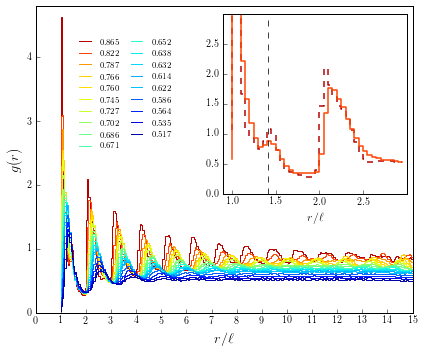

In [ ]:
# Plot g(r)
save = True
margin = 2
show_pks = False
plot_extras = False # all the peaks-only plots (figures 2--4)
fig = plt.figure(1, figsize=(6,5))# if save else (16,12))
rc('text', usetex=save)
main = plt.gca()
inx, iny = .525, .45 # left, bottom
inset = plt.axes([inx, iny, 1-inx-.05, 1-iny-.05])
for n in reversed(ns):
    dens = density[margin][n]
    c = col(dens)
    g, r, dg = gs[n] * [[S*S], [1/S], [S*S]]
    pk = pks[n].T
    label = "{:0.3f}".format(dens)
    #label = "{:.1%}".format(dens)
    #if save: label = label[:-1]+r'\%'
    main.step(r, g, ls='-', where='pre', label=label, color=c, lw=1)
    if dens > .82:
        inset.step(r[r<3], g[r<3], where='pre',
                   ls='-' if dens<.85 else '--', color=c, lw=1.5)
    #axhline(dens, color=c)
    if show_pks:
        main.plot(*pk, marker='s', ls='', color=c, markersize=4)#markeredgecolor='none'
    if plot_extras:
        plt.figure(2, figsize=smallfig)
        plt.plot(dens, pk[0,0], '>', color=c)
        plt.scatter(dens, pk[0,1], marker='>', color=c, s=4)
        plt.figure(3, figsize=smallfig)
        plt.plot(dens, pk[1,0], '^', color=c)
        plt.scatter(dens, pk[1,1], marker='^', color=c, s=4)
        plt.figure(4, figsize=smallfig)
        plt.scatter(dens, g.mean(), marker='o', color=c, s=6)

inset.set_xlim(.9, 3)
inset.set_xticklabels(np.arange(.5, 3, 0.5))
inset.tick_params(top='off', right='off')
diagline = sqrt(2)#/densities[margin][-1]
inset.axvline(diagline, 0, 1, ls='--', color='k', alpha=.75)
ylim = (0, 3)
inset.set_ylim(*ylim)
inset.set_yticklabels(np.arange(ylim[0], ylim[1], 0.5))
inset.set_xlabel('$r/\ell$', fontsize='large')
#inset.set_ylabel('$g(r)$', fontsize='large')
main.legend(loc=(.1,.52), ncol=2, fontsize='small',
            frameon=False, columnspacing=1)# title='density')
#main.set_title("Pair correlation function")
main.set_xlabel("$r/\ell$", fontsize='x-large')
main.set_ylabel("$g(r)$", fontsize='x-large')
main.set_xlim(0,15)
main.set_ylim(0,4.8)
main.set_xticks(range(16))
main.set_xticklabels(range(16))
main.tick_params(top='off', right='off')
#ylim(0,2.5)
#savefig(savedir+"gr_high_density.pdf")
if save: fig.savefig(savedir+"gr_fullsize.pdf")

if plot_extras:
    plt.figure(2)
    plt.plot(densities[margin], 1/np.sqrt(densities[margin]),
             'k-', lw=.5, label=r'$1/\sqrt{\rho}$')
    plt.plot(densities[margin], 2/np.sqrt(densities[margin]),
             'k-', lw=.5, label=r'$2/\sqrt{\rho}$')
    plt.title(r'Distance to first two peaks')
    plt.legend(loc='best')#, fontsize='small')
    plt.ylabel("$r/\ell$", fontsize='x-large')
    plt.xlabel(r"density $\rho$", fontsize='x-large')
    if save: plt.savefig(savedir+"gr_peak_distance.pdf")

    plt.figure(3)
    plt.xlabel(r'density $\rho$', fontsize='x-large')
    plt.title(r'Height of first two peaks')
    if save: plt.savefig(savedir+"gr_peak_height.pdf")

    plt.figure(4)
    plt.plot(densities[margin], densities[margin], 'k-')
    plt.title("mean of $g(r)$, approximate asymptote")
    plt.xlabel(r'density $\rho$')
    if save: plt.savefig(savedir+"gr_mean.pdf")

In [ ]:
## Generate fits to g(r) peaks
gr_fits = { name: {} for name in decays }
gr_fiterr = { name: {} for name in decays }
gr_chi2 = { name: {} for name in decays }
do_resids = True
A = 'f' # coeff amplitude: 'f' for free to fit, '1' for 1, 'g1' for first value of g
for i, n in enumerate(ns):
    g, r, dg = gs[n] * [[S*S], [1/S], [S*S]]
    x, h = pks[n].T
    offset = g.mean()
    err = dg[np.searchsorted(r, x)]
    for name, decay in decays.iteritems():
        if A=='g1':
            if name=='exp':
                coeff = (h[0]-offset) / exp(x[0]/L) # but what's `L`?
            elif name=='pow':
                coeff = (h[0]-offset)*x[0]**b       # but what's `b`?
        p0 = [1, 1] if A=='f' else [1]
        p, cov = curve_fit(decay, x, (h-offset), p0, sigma=err, absolute_sigma=True)
        p = list(p) + [offset] if A == 'f' else None
        #print name, p
        gr_fits[name][n] = p
        gr_fiterr[name][n] = np.sqrt(np.diag(cov))
        if do_resids:
            f = decay(x, *p)
            resid = (h - f)
            gr_chi2[name][n] = np.dot(resid, resid)/resid.size

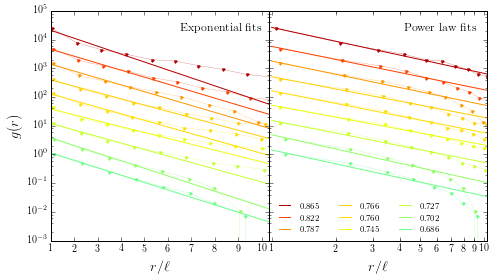

In [ ]:
## Plot fits to g(r)
save = True
margin = 2
rc('figure', autolayout=False)
rc('text', usetex=save)
f1, (l1, r1) = plt.subplots(ncols=2, sharey=True, figsize=(7,4))
do_resids = False
if do_resids:
    f2, (l2, r2) = plt.subplots(ncols=2, sharey=True,
                                figsize=np.array([2,1])*smallfig)
ndens = 9
for i, n in enumerate(ns[-ndens:]):
    sep_factor = 3**i
    g, r, dg = gs[n] * [[S*S], [1/S], [S*S]]
    x, h = pks[n].T
    c = col(density[margin][n])
    offset = g.mean()
    #print n, offset, h
    l1.plot(x, sep_factor*(h-offset), marker='.', ls='-', lw=.2, color=c)
    r1.plot(x, sep_factor*(h-offset), marker='.', ls='-', lw=.2, color=c)
    #errorbar(r, g, dg*sqrt(10), ls='', color=c)
    #print 'fitting {:.1%}'.format(density[margin][n])
    for name, decay in decays.iteritems(): 
        ax = l1 if name=='exp' else r1
        p = gr_fits[name][n]
        ax.plot(r, sep_factor*(decay(r, *p) - offset), label=name, color=c, ls='-')

        if do_resids:
            f = decay(x, *p)
            ax = l2 if name=='exp' else r2
            resid = (h - f)
            ax.plot(x, resid, '-', color=c)
#legend(['$g(r)$','Hilbert transform', '', 'Power law', 'Exponential'],
#       loc='best', ncol=2, fontsize='small')
l1.set_ylabel("$g(r)$", fontsize='x-large')
l1.set_xlabel("$r/\ell$", fontsize='x-large')
l1.set_yscale('log')
l1.set_xlim(1, 10.3)
l1.set_xticks(range(1,11))
l1.set_xticklabels(range(1,11))
#if save: plt.savefig(savedir+"gr_fits_exp_sepfactor3.pdf")

r1.set_xlabel("$r/\ell$", fontsize='x-large')
r1.set_yscale('log')
r1.set_xscale('log')
r1.set_xlim(.97, 10.3)
r1.set_xticks(range(1,11))
r1.set_xticklabels(range(1,11))

yll, yul = l1.get_ylim()
l1.text(6.5, yul/5, "Exponential fits", fontsize='large')
r1.text(4.2, yul/5, "Power law fits", fontsize='large')

handles, labels = r1.get_legend_handles_labels()
#labels = map(lambda s: '{:.2%}'.format(s)[:-1] + r'\%', densities[margin][-ndens:])
labels = map(lambda s: '{:0.3f}'.format(s), densities[margin][-ndens:])
r1.legend(handles[::-1], labels[::-1], ncol=2 if ndens%3 else 3, frameon=False,
          loc='lower left', fontsize='small',)# title=r"Density $\rho=$")

f1.tight_layout()
f1.subplots_adjust(wspace=0)
if save:
    f1.savefig(savedir+"gr_fits.pdf")
#    f1.savefig(savedir+"gr_fits_top{:d}.pdf".format(ndens))

if do_resids:
    l2.set_title('residuals for exp fit')
    l2.set_xlabel("$r$", fontsize='x-large')
    l2.set_xlim(1,10)
    l2.set_ylim(-.2,.2)
    #if save: plt.savefig(savedir+"gr_resid_exp.pdf")

    r2.set_title('residuals for pow fit')
    r2.set_xlabel("$r$", fontsize='x-large')
    r2.set_xlim(1,10)
    r2.set_ylim(-.2,.2)

    if save: f2.savefig(savedir+"gr_resid.pdf")

rc('figure', autolayout=True)

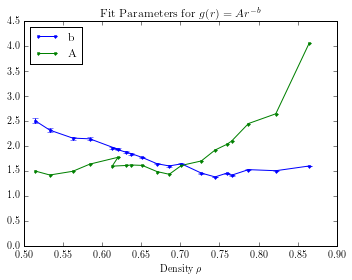

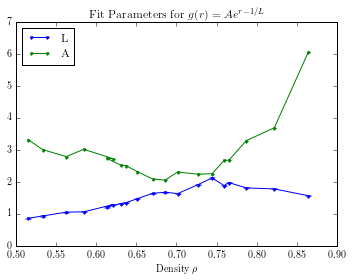

In [ ]:
## Plot the g(r) fitting parameters
save = True
#As = ['f', '1', 'g1'] # 'f' for free/fitted A, '1' for A=1, 'g1' for A=g(1)
#Acol = { A: c for A, c in zip(As, 'rgb')}
A = 'f' #only use A = 'f' for paper
for name in gr_fits:
    plt.figure(figsize=smallfig)
    fitns, fitps = map(np.asarray, zip(*sorted(gr_fits[name].items())))
    fitdens = [density[margin][fitn] for fitn in fitns]
    _, fitperr = map(np.asarray, zip(*sorted(gr_fiterr[name].items())))
    plt.plot(fitdens, fitps[:,:2], lw=1, marker='.')
    plt.errorbar(fitdens, fitps[:, :1], fitperr[:,:1], ls='', c='b')
    plt.legend(['L' if name=='exp' else 'b', 'A'], loc=0,)
               #title='not to scale', fontsize='small')
    plt.xlabel(r'Density $\rho$')
    plt.ylim(0,None)
    plt.title("Fit Parameters for $g(r)={}$".format(
              r"Ae^{r-1/L}" if name is 'exp' else r"Ar^{-b}"))
    if save: plt.savefig(savedir+"gr_fitp_{}_A{}.pdf".format(name, A))

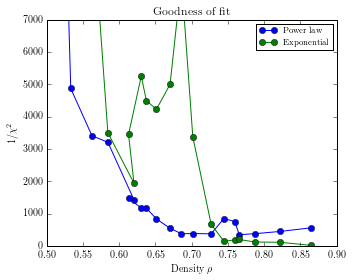

In [ ]:
save = False
plt.figure(figsize=smallfig)
for name in gr_chi2:
    chins, chis = map(np.asarray, zip(*sorted(gr_chi2[name].items())))
    plt.plot(densities[margin], 1/chis, 'o-',
             label="Exponential" if name is 'exp' else "Power law")
plt.legend(loc=0, fontsize='small')
plt.title("Goodness of fit")
plt.xlabel(r'Density $\rho$')
plt.ylabel(r'$1/\chi^2$')
plt.ylim(0, 7e3)
if save: plt.savefig(savedir+"gr_fit_chi2.pdf")

## Distribution function $g(x, y)$

In [ ]:
rmax = 10
nbins = 100
margin = 3
rectang = True
for n, d in sorted(alldata.items())[-3:]:
    for f in np.unique(d['data']['f'])[::10]:
        masks = d['data']['f']==f
        pts = np.column_stack([d['data'][masks]['x'], d['data'][masks]['y']])
        (gxy, _), dangf = corr.distribution(pts, rmax=rmax, bins=nbins,
                                            margin=margin, rectang=rectang)
        sxy = np.fft.fft2(gxy, [int(gxys//sqrt(2)) for gxys in gxy.shape])
        plt.figure()
        plt.subplot(121)
        plt.imshow(np.where(gxy>0, np.log(gxy), -5),
                   extent=[-rmax, rmax]*2, vmin=-5, vmax=0, interpolation='nearest')
        #plt.colorbar()
        plt.title(r"$\rho="+"{:.2%}$, frame {}".format(density[margin][n],f))
        
        plt.subplot(122)
        plt.imshow(np.log(np.abs(sxy)), interpolation='nearest', aspect='equal')
        savefmt = savedir+'gxy_{}-{}_{}rectified.pdf'.format
        plt.savefig(savefmt(n,f,'rhomb-' if rectang else 'un'))
        plt.close()

correlation.py:113: RuntimeWarning: divide by zero encountered in true_divide
  cosalpha = 0.5 * (r**2 + d[dmask]**2 - radius**2) / (r * d[dmask])
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:3934: RuntimeWarning: overflow encountered in exp
  return exp(kappa * cos(x)) / (2*pi*special.i0(kappa))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:3934: RuntimeWarning: invalid value encountered in true_divide
  return exp(kappa * cos(x)) / (2*pi*special.i0(kappa))


ValueError: setting an array element with a sequence.

In [ ]:
rmax = 10
nbins = 100
margin = 3
rectang = True
#rectangs = {}
#dangs = {}
for n, d in sorted(alldata.items(), reverse=True)[2:]:
    print "n =", n
    allpos = [np.column_stack([df['x'], df['y']])
                   for df in helpy.splitter(d['data'], d['data']['f'])]
    rectangs[n], dangs[n] = zip(*(corr.rectify(pos, margin=margin, dangonly=True)
                                  for pos in allpos))
if False:
    gxys = np.dstack([corr.distribution(pos, rmax=rmax, bins=nbins,
                                         margin=margin, rectang=rectang)[0]
                      for pos, rectang in zip(allpos, rectangs)[::10]])
    print "averaging over", gxys.shape[-1], "frames"
    gxy = gxys.mean(-1)
    sxy = np.fft.fft2(gxy, map(int,(gxy.shape[0]//sqrt(2), gxy.shape[1]//sqrt(2))))

    plt.figure(n)
    plt.subplot(121)
    plt.imshow(np.where(gxy>0, np.log(gxy), -5),
               extent=[-rmax, rmax]*2, vmin=-5, vmax=0, interpolation='nearest')
    plt.colorbar()
    plt.title(r"$\rho="+"{:.2%}$".format(density[margin][n]))
    
    plt.subplot(122)
    plt.imshow(np.log(np.abs(sxy)), interpolation='nearest', aspect='equal')
    savefmt = savedir+'gxy_{}_full.pdf'.format
    plt.savefig(savefmt(n,f,'rhomb' if rectify else 'un'))
    plt.close()
    
if False:
    dangs[n] = np.asarray(dangs[n])
    dangs[n] = dangs[n][np.all(np.isfinite(dangs[n]), 1)]
    plt.figure(n+1, figsize=(18,6))
    plt.subplot(121)
    plt.title('$n = %d$'%n)
    h4 = plt.hist(dangs[n], bins=np.linspace(0, tau, 361),
                #tau/8, 3*tau/8, 91),
                normed=True, label="larger smaller large' small'".split())
    plt.legend()
    plt.subplot(122)
    h2 = plt.hist(np.vstack([dangs[n][:,::2], dangs[n][:,1::2]]),
                bins=np.linspace(tau/8, 3*tau/8, 91),
                normed=True, label="larger smaller".split())
    plt.legend()
    plt.show()

n = 416
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
n = 408
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
n = 400
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four peaks, using one
Can't find four pea

## Structure Factor

In [ ]:
for n, d in sorted(alldata.items())[-2:-1]:
    print 'n =', n
    for f in np.unique(d['data']['f'])[:1]:
        print '\tf =',f
        masks = d['data']['f']==f
        pts = np.column_stack([d['data'][masks]['x'], d['data'][masks]['y']])
        sk = corr.structure_factor(pts)

n = 432
	f = 0


## Pair / Bond angle Order Parameter $\Psi_m$ and Correlation function $g_m^\text{pair}(r)$

### Order Parameter $\Psi_m$

In [ ]:
# Uncomment to initiate variables
#psim = {}
#psim_err = {}
#gms_pair = {}

In [ ]:
rmax = 10*S # r of dish is ~12.7
dr = .1*S
rbins = np.arange(S-dr/2, rmax+3*dr/2, dr)
rs = np.arange(S, rmax+dr, dr)

margin = 2

for m in [4, 6]:
    psim[m] = []
    psim_err[m] = []
    gms_pair[m] = {}

    for n, d in sorted(alldata.iteritems())[:]:
        #print 'n:', n
        fs = np.unique(d['data']['f'])
        gm_pair = np.empty(fs.shape+rs.shape, np.complex)
        psimn = []
        for f in fs:
            fmask = d['data']['f']==f
            #print 'n_fmask:', np.count_nonzero(fmask)
            pts = np.column_stack([d['data'][fmask]['x'], d['data'][fmask]['y']])
            #assert np.count_nonzero(fmask) == len(pts), 'npts != nfmask'
            ang, nmask, dmask = corr.pair_angles(pts, m, margin=margin, dub=2*S)
            #print len(ang)
            psimf = corr.pair_angle_op(ang, nmask, m=m)[2]
            gm_pair[f]= corr.pair_angle_corr(pts[dmask], psimf, rbins)[0]
            psimn.append(np.abs(np.nanmean(psimf)))
        gms_pair[m][n] = np.nanmean(gm_pair, 0).real, np.nanstd(gm_pair.real, 0), rs
        psim[m].append(np.nanmean(psimn))
        psim_err[m].append(np.nanstd(psimn))

In [ ]:
# Uncomment to initiate variables
#angles = {}
#primary_angles = {}

In [ ]:
m = None #integer for m nearest neighbors, None for voronoi/delaunay
angtype = 'delta'
for m, angtype in it.product([4, 6, None], ['delta', 'absolute', 'relative']):
    angles[m, angtype] = {}
    for n, d in sorted(alldata.iteritems()):
        fs = np.unique(d['data']['f'])
        angles[m, angtype][n] = []
        for f in fs:
            masks = (d['data']['f']==f) & d['omask']
            pts = np.column_stack([d['data'][masks]['x'], d['data'][masks]['y']])
            ang, nmask, dmask = corr.pair_angles(pts, m, angtype,
                                                 margin=margin, dub=2*S)
            angles[m, angtype][n].append(ang[nmask].ravel())

correlation.py:431: RuntimeWarning: invalid value encountered in subtract
  elif ang_type != 'absolute':


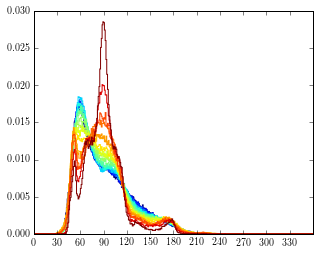

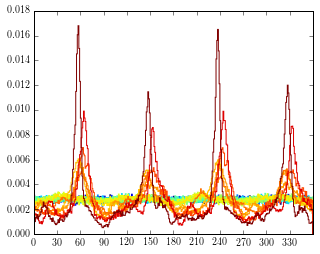

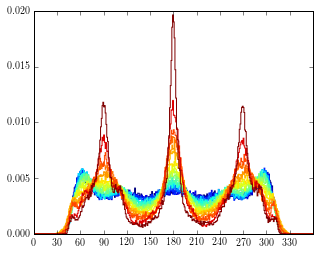

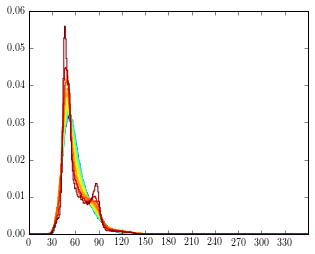

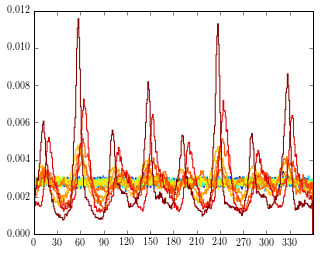

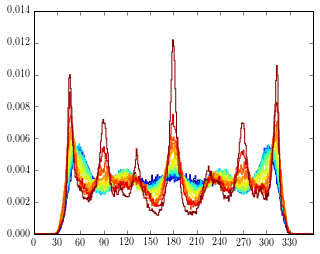

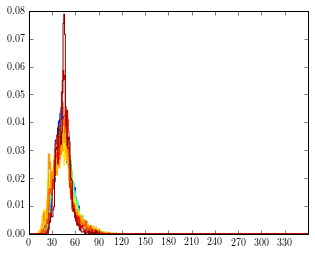

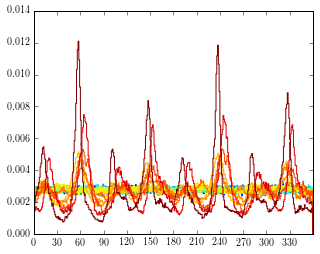

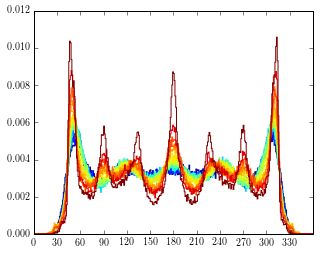

In [ ]:
for m, angtype in it.product([4, 6, None], ['delta', 'absolute', 'relative']):
    plt.figure(figsize=smallfig)
    for n in ns:
        allangles = np.concatenate(angles[m, angtype][n])
        allangles = allangles[allangles!=0].flat
        th = 0, 360
        plt.xlim(th)
        plt.hist(np.degrees(allangles), th[1]-th[0], th, True,
                 histtype='step', color=col(density[margin][n]))
        plt.xticks(np.arange(*th, step=30))
    plt.savefig(savedir+"pairangle_hist_{}_{}.pdf".format(
                'voronoi' if m is None else m, angtype))

In [ ]:
class vonmises_4(rv_continuous):
    def __init__(self):
        rv_continuous.__init__(self, a=0, b=tau)

    def _pdf(self, x,
             k1, k2, k3, k4,
             l1, l2, l3, l4,
             a1, a2, a3, a4,
             c):
        #a1 = a2 = a3 = .25
        #if a1 is None: a1 = .25
        #if a2 is None: a2 = .25
        #if a3 is None: a3 = .25
        #assert min(a1, a2, a3) >= 0
        #a4 = 1 - a1 - a2 - a3
        return a1*vonmises.pdf(x, k1, l1) + \
               a2*vonmises.pdf(x, k2, l2) + \
               a3*vonmises.pdf(x, k3, l3) + \
               a4*vonmises.pdf(x, k4, l4) + c
                
    def _cdf(self, x,
             k1, k2, k3, k4,
             l1, l2, l3, l4,
             a1, a2, a3, a4,
             c):
        return a1*vonmises.cdf(x, k1, l1) + \
               a2*vonmises.cdf(x, k2, l2) + \
               a3*vonmises.cdf(x, k3, l3) + \
               a4*vonmises.cdf(x, k4, l4) + c*x# % tau)
                
    def _stats_skip(self, *args):
        return 0, None, 0, None

vm4 = vonmises_4()

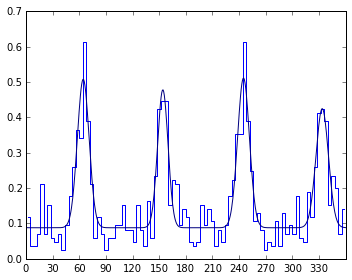

In [ ]:
m = 4
thlim = 0, 360
th = np.arange(*thlim)
for n in ns[-2:-1]:
    plt.figure(figsize=smallfig)
    plt.xlim(thlim)
    for f, angf in enumerate(angles[m, 'absolute'][n][:1]):
        angf = angf[angf!=0].ravel()
        l, k, a, c, h, t = corr.primary_angles(angf, m=m, bins=90, ret_hist=True)
        #print 'k:',k
        #print 'seps:', np.degrees(np.sort(l)-np.roll(np.sort(l),1))%360
        #print 'l % tau:', l % tau
        #print '       :', np.degrees(l % tau), 'degrees'
        #print 'amps:', a
        #print 'c:', c
        plt.step(np.degrees(t), h, where='mid')
        plt.plot(np.linspace(*thlim, num=500),
                 corr.vm4_pdf(np.radians(np.linspace(*thlim, num=500)),
                              *np.r_[l,k,a,c]),
                 color=col(f/10))
    plt.xticks(np.arange(*thlim, step=30))
    #plt.ylim(0, .03)
plt.savefig(savedir+"pairangle_hist_absolute.pdf")

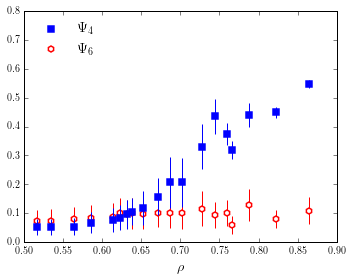

In [ ]:
# Plot the Pair Angle Order Parameters Psi_m
save = True
plt.figure(figsize=smallfig)
fmt = {4: 'sb', 6: 'hr'}
for m in [4,6]:
    plt.plot(densities[margin], psim[m], fmt[m],
             #label=r'$\Psi_{:d}$ ({})'.format(m, ["Hexagonal", "Square"][m==4]),
             label=r'$\Psi_{:d}$'.format(m),
             markeredgecolor=fmt[m][-1],
             markerfacecolor='w' if m==6 else None,
             markeredgewidth=1.5,
             zorder=7-m)
    plt.errorbar(densities[margin], psim[m], psim_err[m],
                 ls='', color=fmt[m][-1], capsize=0, zorder=6.5-m)
plt.ylim(0,.8)
#plt.title("Pair/Bond angle order parameter")
plt.xlabel(r'$\rho$', fontsize='x-large')
#plt.ylabel(r'$\Psi_m$')
plt.legend(loc='upper left', fontsize='x-large', numpoints=1, frameon=False)
if save: plt.savefig(savedir+"pairangle_order_params.pdf")

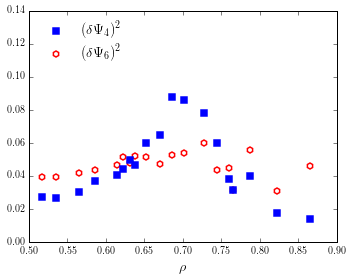

In [ ]:
# Plot Variance of the Pair Angle Order Parameters Psi_m
save = True
rc('text', usetex=save)
plt.figure(figsize=smallfig)
fmt = {4: 'sb', 6: 'hr'}
for m in [4,6]:
    plt.plot(densities[margin], psim_err[m], fmt[m],
             #label=r'$\Psi_{:d}$ ({})'.format(m, ["Hexagonal", "Square"][m==4]),
             label=r'$(\delta\Psi_{:d})^2$'.format(m),
             markeredgecolor=fmt[m][-1],
             markerfacecolor='w' if m==6 else None,
             markeredgewidth=1.5,
             zorder=7-m)
plt.ylim(0,.14)
plt.xlabel(r'$\rho$', fontsize='x-large')
plt.legend(loc='upper left', fontsize='x-large', numpoints=1, frameon=False)
if save: plt.savefig(savedir+"pairangle_order_variance.pdf")

### Correlation function $g_m^\psi(r)$

In [ ]:
#gm_pair_fits = {'exp': {}, 'pow': {}}
#gm_pair_fiterr = {'exp': {}, 'pow': {}}

In [ ]:
# Generate fits for gm_pair(r), bond-angle corrlation function
gm_pair_A = 'f' # 'f' for free/fitted A, '1' for A=1, 'g1' for A=g(1)
A = gm_pair_A   # only use A = 'f' for paper
for decay in ['exp', 'pow']:
    m = 4
    r0 = decay=='exp'
    gm_pair_fits[decay][m] = {}
    gm_pair_fiterr[decay][m] = {}
    for A in As:
        gm_pair_fits[decay][m][A] = {}
        gm_pair_fiterr[decay][m][A] = {}
        for n, (gm_pair, dgm_pair, rs) in sorted(gms_pair[m].items()):
            if A == 'f':
                guess = [1,1]
                fit_func = decays[decay]
                pappendix = []
            elif A == '1':
                guess = [1]
                fit_func = decays[decay]
                pappendix = [1]
            elif A == 'g1':
                guess = [1]
                fit_func = lambda x, a: decays[decay](x, a, gm_pair[1])
                pappendix = [gm_pair[1]]
            p, cov = curve_fit(fit_func, rs/S - r0, gm_pair,
                               guess, sigma=dgm_pair, absolute_sigma=True)
            #print "N = {}, cov = {}, fit = {}".format(n, np.linalg.norm(cov), p)
            if np.isfinite(np.linalg.norm(cov)):
                gm_pair_fits[decay][m][A][n] = p.tolist() + pappendix
                gm_pair_fiterr[decay][m][A][n] = np.sqrt(np.diag(cov))
            else:
                print 'no finite {} fit for n = {} with A = {}'.format(decay, n, A)

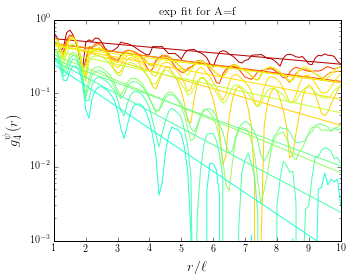

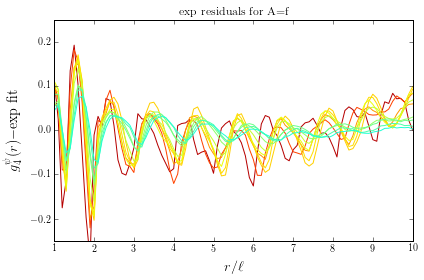

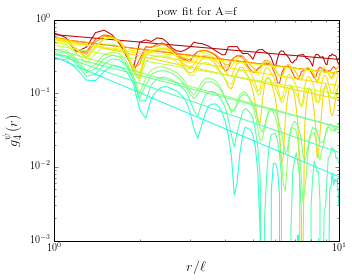

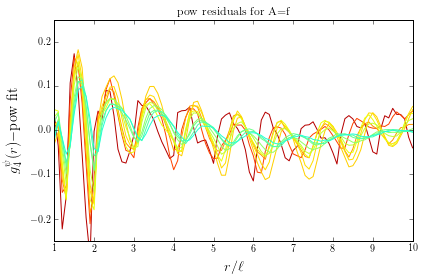

In [ ]:
# Plot gm_pair(r) and its fits
save = True
plot_fit = True

m = 4
As = ['f',
      #'g1',
      #'1',
     ]
for An, A in enumerate(As):
    for dn,decay in enumerate(['exp', 'pow']):
        r0 = decay=='exp'
        for n, (gm_pair, dgm_pair, rs) in sorted(gms_pair[m].items(), reverse=True):
            dens = density[margin][n]
            if dens < .65: continue
            plt.figure(1+An*2+4*dn, figsize=smallfig)
            plt.plot(rs/S, gm_pair, ls='-', color=col(dens))
            if plot_fit:
                f = decays[decay](rs/S - r0, *gm_pair_fits[decay][m][A][n])
                plt.plot(rs/S, f, color=col(dens))
                plt.title(decay+' fit for A='+A)

                plt.figure(2+An*2+4*dn)
                resid = (gm_pair - f)
                plt.plot(rs/S, resid, color=col(dens))

        plt.figure(1+An*2+4*dn)
        plt.xlim(1,10)
        plt.ylim(1e-3,1)
        plt.ylabel(r"$g^\psi_"+str(m)+r'(r)$', fontsize='x-large')
        plt.xlabel('$r/\ell$', fontsize='x-large')
        plt.yscale('log')
        if decay=='pow':
            plt.xscale('log')
        if plot_fit:
            if save:
                plt.savefig(savedir+"g{}_pair_{}_A={}.pdf".format(m, decay, A))
            plt.figure(2+An*2+4*dn)
            plt.title(decay+' residuals for A='+A)
            plt.ylabel(r"$g^\psi_{}(r) - ${} fit".format(m, decay), size='x-large')
            plt.xlabel('$r/\ell$', size='x-large')
            plt.ylim(-.25,.25)
            plt.xlim(1,10)
            if save:
                savefmt = savedir+"g{}_pair_{}_resid_A={}.pdf".format
                plt.savefig(savefmt(m, decay, A))
        else:
            if save:
                savefmt = savedir+"g{}_pair_{}log.pdf".format
                plt.savefig(savefmt(m, 'semi' if decay=='exp' else 'log'))

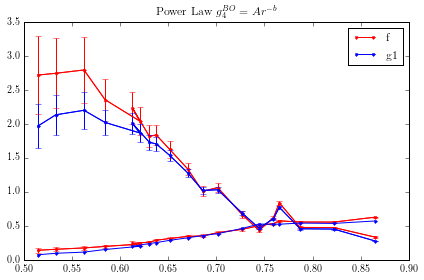

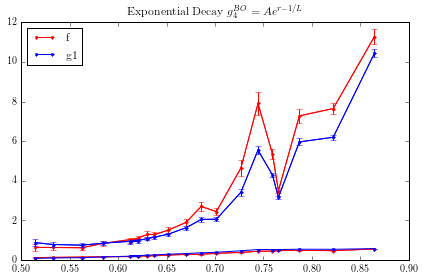

In [ ]:
## Plot the fitting parameters for gm_pair(r)
titles = {'exp': r'Exponential Decay $g_4^{BO} = Ae^{r-1/L}$',
          'pow': r'Power Law $g_4^{BO} = Ar^{-b}$'}
As = ['f',# '1',
      'g1']
m = 4
for decay in ['pow', 'exp']:
    plt.figure()
    handles = []
    for A in As:
        fitns, fitps = np.asarray(sorted(gm_pair_fits[decay][m][A].items())).T
        fitdens = [density[margin][fitn] for fitn in fitns]
        fitperr = np.asarray(sorted(gm_pair_fiterr[decay][m][A].items()))[:,1]
        handle, _ = plt.plot(fitdens, fitps, # fitps[:, :(1 if A=='1' else 2)]
                             lw=1, marker='.', label=A, color=Acol[A])
        for pN in range(fitperr.shape[1]):
            plt.errorbar(fitdens, fitps[:,pN], fitperr[:, pN], c=Acol[A])
        plt.title(titles[decay])
        #if A!='1': plt.legend(['$L$', '$A$'], loc='best')
        #if A!='1': plt.legend(['$b$', '$A$'], loc='best')
        handles.append(handle)
    plt.legend(handles, As, loc=0)
    plt.savefig(savedir+"g4_pair_fitp_{}_no1.pdf".format(decay, A))

## Summarizing Plots

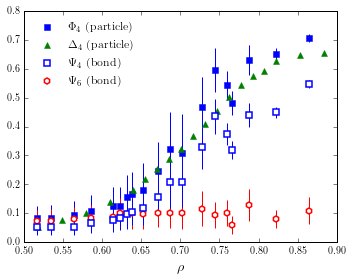

In [ ]:
# ORDER PARAMS:
# Plot all order parameters together in one frame

#rcParams("text", latex.preamble= r"\usepackage{graphicx}") # is latex.preamble synatx right?
save = True
graphicsdir = '/Users/leewalsh/Physics/Squares/writing/graphics/'
plt.figure(figsize=smallfig)
fmt = {4: 'sb', 6: 'hr'}
#label = r'$\P{}i_{:d}$ ({}) \includegraphics[width=.5in]{{{}}} .'.format
icon = lambda x: np.asarray(Image.open(graphicsdir+"angles_{}_icon.png".format(x)))
label = r'$\P{}i_{:d}$ ({})'.format
m=4
plt.plot(densities[margin], globphi[m], fmt[m],
         label=label('h', m, 'particle'), markeredgecolor=fmt[m][-1])
plt.errorbar(densities[margin], globphi[m], globphi_err[m],
             ls='', color=fmt[m][-1], capsize=0)
plt.plot(densities[0], 1 - np.asarray(diff_std)*sqrt(12)*4/tau,
         '^', label=r'$\Delta_4$ (particle)', color='g', markeredgecolor='g')
for m in [6,4 ]:
    plt.plot(densities[margin], psim[m], fmt[m], label=label('s', m, 'bond'),
             markeredgecolor=fmt[m][-1], markerfacecolor='w', markeredgewidth=1.5)
    plt.errorbar(densities[margin], psim[m], psim_err[m], ls='', color=fmt[m][-1], capsize=0)

#plt.title("Order Parameters", fontsize='x-large')
plt.xlabel(r'$\rho$', fontsize='x-large')
plt.ylim(0,.8)
handles, labels = plt.gca().get_legend_handles_labels()
handles.insert(-1, handles.pop(-1))
labels.insert(-1, labels.pop(-1))
plt.legend(handles, labels,
           loc='best', numpoints=1, fontsize='large', frameon=False)
plt.draw()

#plt.imshow(icon(icon_type), extent=[.5, .6, .7, .8])
if False:
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    for icon_type, icon_loc in zip(['particle', 'bond'], [(.7,.75), (.7, .6)]):
        imagebox = OffsetImage(icon(icon_type), zoom=1, dpi_cor=False,
                               interpolation='nearest')
        ab = AnnotationBbox(imagebox, icon_loc,
                    #xybox=None,#(10, 10),
                    xycoords='data',
                    #boxcoords="offset points",
                    #pad=0,
                    frameon=False,
                    #arrowprops=None,
                    )
        plt.gca().add_artist(ab)
    
if save: plt.savefig(savedir+"order_params_oneframe.pdf")#, dpi=600)

In [ ]:
def insert_icons(fig, locs, scale, icon_dir=None, icon_type='angles', names=None):
    if icon_dir is None:
        icon_dir = '/Users/leewalsh/Physics/Squares/writing/graphics/'
    if names is None:
        names = ["bond", "particle"] if icon_type=='angles' else ["trans", "rot"]
    locs = [0, .50], [.50, .525] # [left, bottom]
    for loc, name in zip(locs, names):
        im = plt.imread('{}{}_diagram_{}.png'.format(icon_dir, icon_type, name))
        rect = loc + [im.shape[1]*scale, im.shape[0]*scale]
        print ', '.join(["{:04.3f}"]*4).format(*rect)
        icax = fig.add_axes(rect)
        icax.imshow(im)
        icax.axis('off')
        #icax.draw()

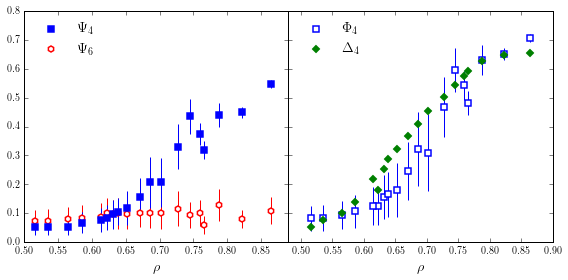

In [ ]:
# Plot all the Order Parameters -- SIDE-by-SIDE
# Psi_m | Phi_m and Delta_m
save = True
icons = False

f = plt.figure(figsize=(8,4))
gspec = gridspec.GridSpec(1,2)
gspec.update(wspace=0)
axl = plt.subplot(gspec[0])
axr = plt.subplot(gspec[1])

fmt = {4: 'sb', 6: 'hr'}
margin = 2

## Psi_m ##
for m in [6,4]:
    axl.plot(densities[margin], psim[m], fmt[m],
             #label=r'$\Psi_{:d}$ ({})'.format(m, "Square" if m==4 else "Hexagonal"),
             label=r'$\Psi_{:d}$'.format(m),
             markeredgecolor=fmt[m][-1],
             markerfacecolor='w' if m==6 else None,
             markeredgewidth=1.5)
    axl.errorbar(densities[margin], psim[m], psim_err[m], ls='', color=fmt[m][-1], capsize=0)
axl.set_ylim(0,.8)
axl.set_xlim(.5,.89)
#axl.set_title("Pair/Bond angle order parameter")
axl.set_xlabel(r'$\rho$', fontsize='x-large')
#axl.set_ylabel(r'$\Psi_m$')
handles, labels = axl.get_legend_handles_labels()
axl.legend(handles[::-1], labels[::-1],
           loc='upper left', fontsize='x-large', numpoints=1, frameon=False)

## Phi_m, Delta_m ##
for m in [4,]:
    #axr.plot(densities[0], locphi[m], shape[m],
    #         label='local '+r'$\Phi_{:d}$'.format(m), color='g')
    #axr.errorbar(densities[0], locphi[m], locphi_err[m], ls='', color='g')
    axr.plot(densities[margin], globphi[m], fmt[m],
             label=r'$\Phi_{:d}$'.format(m),
             #label=r'$\Phi_{:d}$ ({}atic)'.format(m, 'Tetr' if m==4 else 'Hex'),
             markeredgecolor=fmt[m][-1],
             markerfacecolor='w',
             markeredgewidth=1.5)
    axr.errorbar(densities[margin], globphi[m], globphi_err[m]
                 , ls='', color=fmt[m][-1], capsize=0)
axr.plot(densities[margin], 1 - np.asarray(diff_std)*sqrt(12)*4/tau,
         ls='', marker=(4, 0, 1), ms=8, color='g', markeredgecolor='g',
         label=r'$\Delta_4$',) #margin=0 here
#plt.title('Particle orientational order parameter')
axr.set_xlabel(r'$\rho$', fontsize='x-large')
axr.set_xlim(.48, None)
axr.set_ylim(0, 0.8)
axr.set_yticklabels([])
axr.legend(loc='upper left', numpoints=1, fontsize='x-large', frameon=False)

if icons:
    locs = [0, .50], [.50, .525] # [left, bottom]
    insert_icons(f, locs, scale=1.2e-3)

if save:
    f.savefig(savedir+"order_params{}.pdf".format('_icons'*icons))

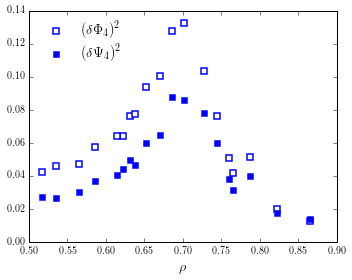

In [59]:
# Plot Variances of Particle Orientaion and Pair Angle Order Parameters
# Phi_m and Delta_m; and Psi_m
save = True
rc('text', usetex=save)
plt.figure(figsize=smallfig)
fmt = {4: 'sb', 6: 'hr'}
margin = 2
m = 4
plt.plot(densities[margin], globphi_err[m], fmt[m],
         label=r'$(\delta\Phi_{:d})^2$'.format(m),
         markeredgecolor=fmt[m][-1],
         markeredgewidth=1.5,
         markerfacecolor='w')
plt.plot(densities[margin], psim_err[m], fmt[m],
         #label=r'$\Psi_{:d}$ ({})'.format(m, ["Hexagonal", "Square"][m==4])
         label=r'$(\delta\Psi_{:d})^2$'.format(m),
         markeredgecolor=fmt[m][-1],
         markerfacecolor=None)
plt.xlabel(r'$\rho$', fontsize='x-large')
plt.legend(loc='upper left', numpoints=1, fontsize='x-large', frameon=False)
#legend from psi OP:
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(handles[::-1], labels[::-1],
#           loc='upper left', fontsize='x-large', numpoints=1, frameon=False)
if save: plt.savefig(savedir+"order_variances.pdf")

In [ ]:
np.column_stack([ns, ns/N, densities[margin]])

array([[ 272.        ,    0.51806763,    0.51457468],
       [ 288.        ,    0.54854219,    0.53312525],
       [ 304.        ,    0.57901676,    0.56242684],
       [ 320.        ,    0.60949133,    0.58430467],
       [ 336.        ,    0.63996589,    0.62029501],
       [ 344.        ,    0.65520318,    0.6128287 ],
       [ 352.        ,    0.67044046,    0.63037252],
       [ 360.        ,    0.68567774,    0.63749976],
       [ 368.        ,    0.70091502,    0.65131972],
       [ 376.        ,    0.71615231,    0.67012727],
       [ 384.        ,    0.73138959,    0.68577812],
       [ 392.        ,    0.74662687,    0.70148425],
       [ 400.        ,    0.76186416,    0.72676463],
       [ 408.        ,    0.77710144,    0.74444065],
       [ 416.        ,    0.79233872,    0.75938124],
       [ 424.        ,    0.80757601,    0.76549662],
       [ 432.        ,    0.82281329,    0.78711727],
       [ 448.        ,    0.85328786,    0.8220665 ],
       [ 464.        ,    0.

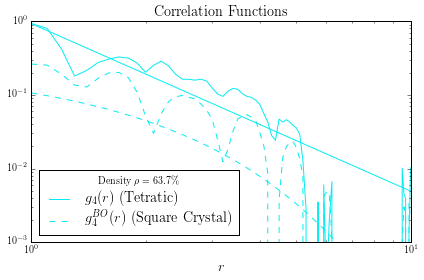

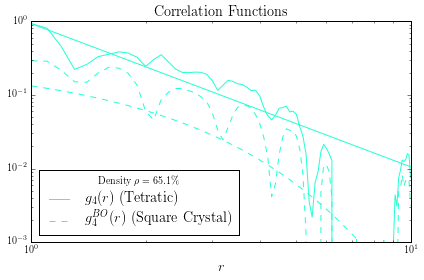

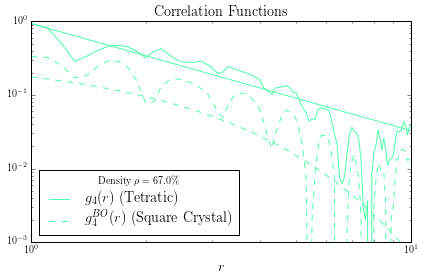

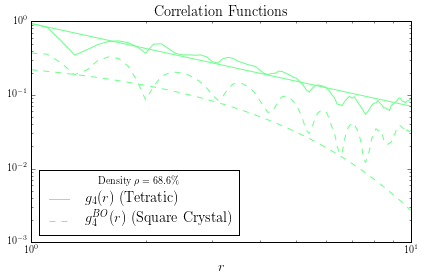

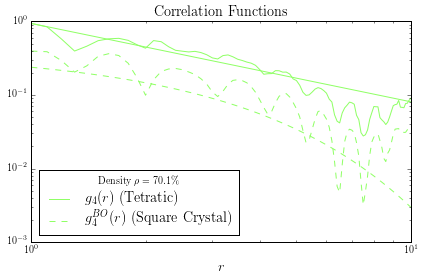

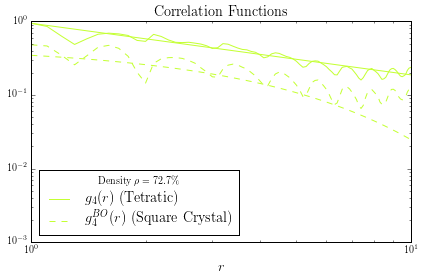

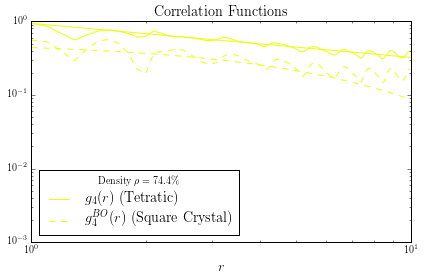

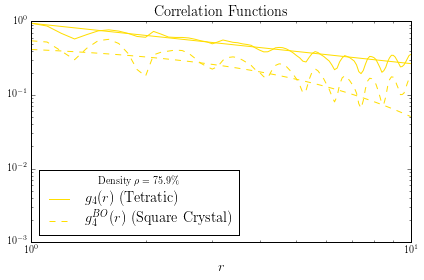

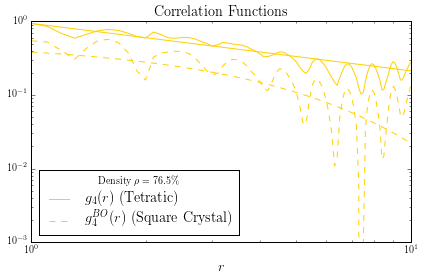

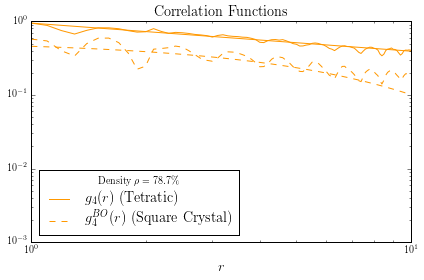

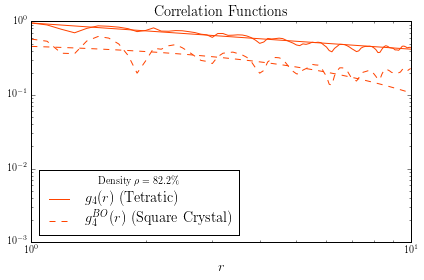

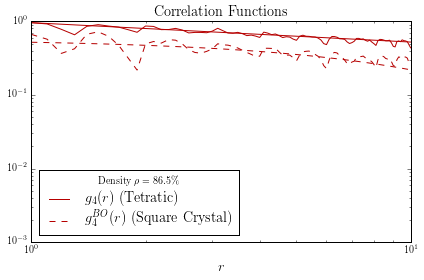

In [ ]:
m = 4
for n in ns[-12:]:
    decay = 'pow'
    r0 = decay=='exp'
    
    (gmr, dgmr, rs) = gms[m][n]
    (gm_pair, dgm_pair, rs_pair) = gms_pair[m][n]
    
    c = col(density[margin][n])
    plt.figure()
    plt.plot(rs/S, gmr, color=c, label='$g_4(r)$ (Tetratic)')
    f = decays[decay](rs/S - r0, *gm_fits[decay][m][A][n])
    plt.plot(rs/S, f, color=c)
    plt.title('Correlation Functions', fontsize='x-large')
    plt.xlabel('$r$', fontsize='x-large')
    #plt.ylabel('$g_{}(r)$'.format(m), fontsize='large')
    plt.ylim(1e-3, 1)
    plt.xlim(1,10)
    plt.yscale('log')
    plt.xscale('log')
    
    decay='exp'
    plt.plot(rs_pair/S, gm_pair, ls='--', color=c, label='$g_4^{BO}(r)$ (Square Crystal)')
    plt.plot(rs_pair/S, decays[decay](rs_pair/S, *gm_pair_fits[decay][m][A][n]), '--', color=c)
    
    plt.legend(loc='best', fontsize='x-large',
               title=('Density $\\rho = {:.1f}\\%$                           '
                     '').format(100*density[margin][n]))
    plt.savefig(savedir+"g{}s_{}_{}.pdf".format(m, decay, n))
    #savefig(savedir+"g{}s_{}log.pdf".format(m, 'semi' if r0 else 'log'))#, decay))
    #figure(2)
    #savefig(savedir+"g{}_{}_resid.pdf".format(m, decay))

TypeError: 'bool' object is not callable

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


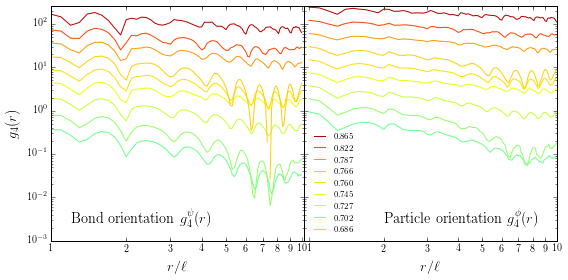

In [ ]:
# CORRELATION FUNCTIONS
# Plot both correlation functions:
# gm (phi) and gm_pair (psi)
save = False
insert_icons = True
decay = 'pow'
m = 4

#f, (axl, axr) = plt.subplots(ncols=2, sharey=True, figsize=(8,4))
f = plt.figure(figsize=(8,4))
gspec = gridspec.GridSpec(1,2)
gspec.update(wspace=0)
axl = plt.subplot(gspec[0])
axr = plt.subplot(gspec[1])
ndens = 9
nrange = slice(-ndens,None,None)
for i,n in enumerate(ns[nrange]):
    sep_factor = 2**i
    gm, dgm, gmrs = gms[m][n]
    gm_pair, dgm_pair, gm_pair_rs = gms_pair[m][n]
    assert np.allclose(gmrs, gm_pair_rs)
    rs = gmrs
    label = '{:<05.3}'.format(density[margin][n])
    color = col(density[margin][n])
    axl.plot(rs/S, sep_factor*np.where(gm_pair>1e-4, gm_pair, np.nan),
             color=color, label=label)
    axr.plot(rs/S, sep_factor*np.where(gm>1e-4, gm, np.nan),
             color=color, label=label)

yll = {8:1e-3, 9:1e-3, 10:3e-4, 11:1e-4}
for ax in [axl, axr]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(yll[ndens], sep_factor) # last sep_factor is the effective "1" for top curve
    ax.set_xticks(range(1,11))
    ax.set_xticklabels(range(1,11))
    ax.set_xlabel('$r/\ell$', fontsize='x-large')

axl.text(1.2, 2*yll[ndens], "Bond orientation $g_"+str(m)+r'^\psi(r)$',
         fontsize='x-large')
axl.set_xlim(1,10.2)

axr.text(2, 2*yll[ndens], r"Particle orientation $g_"+str(m)+r"^\phi(r)$",
         fontsize='x-large')
axr.set_xlim(.95,10)

axl.set_ylabel('$g_{}(r)$'.format(m), fontsize='x-large')
axr.set_yticklabels([])

legax = axr
handles, labels = legax.get_legend_handles_labels()
legax.legend(handles[::-1], labels[::-1],
           frameon=False, loc='best', fontsize='small')

if icons:
    locs = [0, .50], [.50, .525] # [left, bottom]
    insert_icons(f, locs, scale=1.2e-3)

#f.tight_layout()
#f.subplots_adjust(wspace=None)
if save:
    f.savefig(savedir+"g4s.pdf")
#    f.savefig(savedir+"g4s_top{:d}.pdf".format(ndens))

#plt.xlim(1,10)
#plt.ylim(1e-3,1)
#plt.ylabel("$g_"+str(m)+r'^{BO}(r)$')
#plt.xlabel('$r$', fontsize='large')
#plt.yscale('log')
#if decay=='pow':
#    plt.xscale('log')
#plt.savefig(savedir+"g{}_pair_{}.pdf".format(m, decay))
#plt.savefig(savedir+"g{}_pair_{}log.pdf".format(m, 'semi' if decay=='exp' else 'log'))


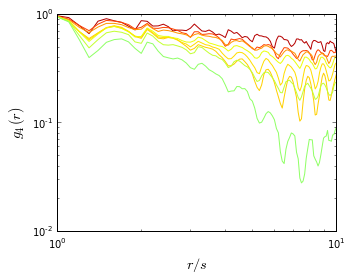

In [ ]:
#COPIED FROM g_4(r) PLOT ABOVE
m = 4
decay = '' # empty string for none, else 'exp' or 'pow'
for n, (gmr, dgmr, rs) in sorted(gms[m].items(), reverse=True):
    if decay and n not in gm_fits[decay][m][A]: continue
    if n < ns[-8]: continue
    plt.figure(1, figsize=smallfig)
    plt.plot(rs/S, gmr, color=col(density[margin][n]))

plt.figure(1)
#plt.title('Particle orientation correlation')
plt.xlabel('$r/s$', fontsize='x-large')
plt.ylabel('$g_{}(r)$'.format(m), fontsize='x-large')
plt.ylim(1e-2, 1)
plt.xlim(1,10)
plt.yscale('log')
plt.xscale('log')
#plt.savefig(savedir+"g{}_{}log.pdf".format(m, 'semi' if r0 else 'log'))


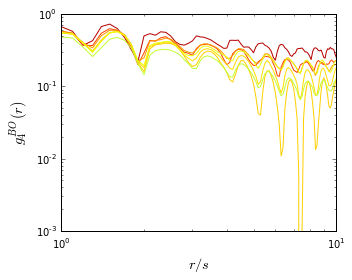

In [ ]:
#COPIED FROM g_4^{BO}(r) PLOT ABOVE
decay = 'pow'
plot_fit = False
m = 4
for n, (gm_pair, dgm_pair, rs) in sorted(gms_pair[m].items(), reverse=True):
    if density[margin][n] < .72: continue
    plt.figure(1, figsize=smallfig)
    plt.plot(rs/S, gm_pair, ls='-', color=col(density[margin][n]))

plt.figure(1)
plt.xlim(1,10)
plt.ylim(1e-3,1)
plt.ylabel("$g_"+str(m)+r'^{BO}(r)$', fontsize='x-large')
plt.xlabel('$r/s$', fontsize='x-large')
plt.yscale('log')
plt.xscale('log')
plt.savefig(savedir+"g{}_pair_{}log.pdf".format(m, 'semi' if decay=='exp' else 'log'))

In [ ]:
col(.5)

(0.0, 0.0, 0.589126559714795, 1.0)

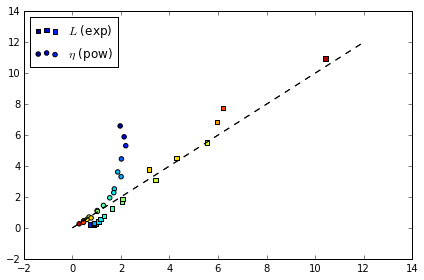

In [ ]:
## Comparing Orientational to Translational decay parameters
m = 4
A = 'g1'
for decay in ['exp', 'pow']:
    gm_ns, gm_ps = map(np.asarray, zip(*sorted(gm_fits[decay][m][A].items())))
    #? gm_ns, gm_ps = np.asarray(sorted(gm_fits[decay][m][A].items())).T
    gm_dens = [density[margin][gm_n] for gm_n in gm_ns]
    gm_pair_ns, gm_pair_ps = map(np.asarray,
                                 zip(*sorted(gm_pair_fits[decay][m][A].items())))
    #? gm_pair_ns, gm_pair_ps = np.asarray(sorted(gm_pair_fits[decay][m][A].items())).T
    i = np.searchsorted(gm_pair_ns, gm_ns[0])
    assert np.allclose(gm_pair_ns[i:], gm_ns)
    plt.scatter(gm_pair_ps[i:,0], gm_ps[:,0], c=col(gm_dens),
                marker='s' if decay=='exp' else 'o',
                label='$L$ (exp)' if decay=='exp' else '$\eta$ (pow)')
    plt.plot(np.linspace(0,12), np.linspace(0,12), '--k')
    plt.legend(loc=0)